1. DFS design and implementation
1. Networked File System (NFS)
1. "Caching in the Sprite Network File System" By Nelson et al.

 1. Accessed via well-defined interface
     1. access via VFS (virtual file system)
 1. Focus on consistent state
     1. tracking state
     1. file updates
     1. cache coherence
 1. Mixed distribution models possible
     1. replicated vs partitioned
     1. peer-like system

### DFS Models
1. client/server on different machines
1. file server distributed on multiple machines
    1. replicated (each server: all files) (data safety & avaiability)
    1. partitioned (each server: part of files) (more scaleable)
    1. both (files partitioned, each partition replicated)
1. files stored on and serverd from all machines (peers)
    1. burred distinction between clients and servers

### Remote File Service: extremes
1. 1 upload/download
    1. like FTP SVN
    1. file moved to client
    1. accesses are done on client
    1. when client is done, file is returned to server
    1. pros:
        1. local reads/writes at client
    1. cons:
        1. entire file download/upload even for small accesses
        1. server gives up control
1. True Remote File Access
    1. every access to remote file 
    1. nothing done locally
    1. files stays on server
    1. Request from client to access remote file
    1. pros: 
         1. file accesses centralized
         1. easy to reason about consistency
     1. cons:
         1. every file operattion pays network costs
         1. limits server scalability

### Remote file service: A compromise
1. a more practial Remost File Access (with Caching)
    1. allow clients to store parts of files locally (download/prefetch some blocks clients are accessing)
        1. pros:
            1. low latency on file operations
            1. server load reduced -> more scalable
    1. force clients to interact with serer (frequently)
        1. notify server any modifications
        1. check remote file updates
        1. pros:
            1. server has insights into what clients are doing
            1. server has control into which accesses can be permitted => easier to maintian consistency
        1. cons:
            1. serermore complex
            1. requires different file sharing semantics

### Stateless vs Statefull File Server
1. stateless == keeps no state
    1. doesn't maintain any information regarding
        1. which client is accessing which files
        1. how many clients
    1. all requests have to be self-described
    1. requests have all the parameters regarding the file being accessed etc
    1. OK with extreme models
    1. but can't support practical model
    1. pros:
        1. no resources are used on server side (CPU/Memory)
        1. on failure, just restart, no need for recovery
    1. cons:
        1. cannot support caching and consistency management
        1. every request self-contained => more bits transferred
1. stateful == keeps client state
    1. needed for 'practial' model to track what is cached/accessed
    1. pros:
        1. can support locking, caching, incremental operations
        1. on failure, need check pointing and recovery mechanisms
        1. overhead to maintain state and consistency => depends on caching mechanism and consistency protocol

### Caching State in a DFS (optimization)
1. locally clients maintain portion of state (e.g. file blocks)
1. locally clients perform operations on cached state (e.g. open/read/write...)
1. require coherence mechanisms
    1. shared-memoery multi processors
        1. how: write-update/write-invalidate
        1. when: on write
    1. DFS:
        1. how: 
            1. client driven
            1. server driven
        1. when: 
            1. on demand
            1. periodially
            1. ono open 
1. details depend on file sharing semantics

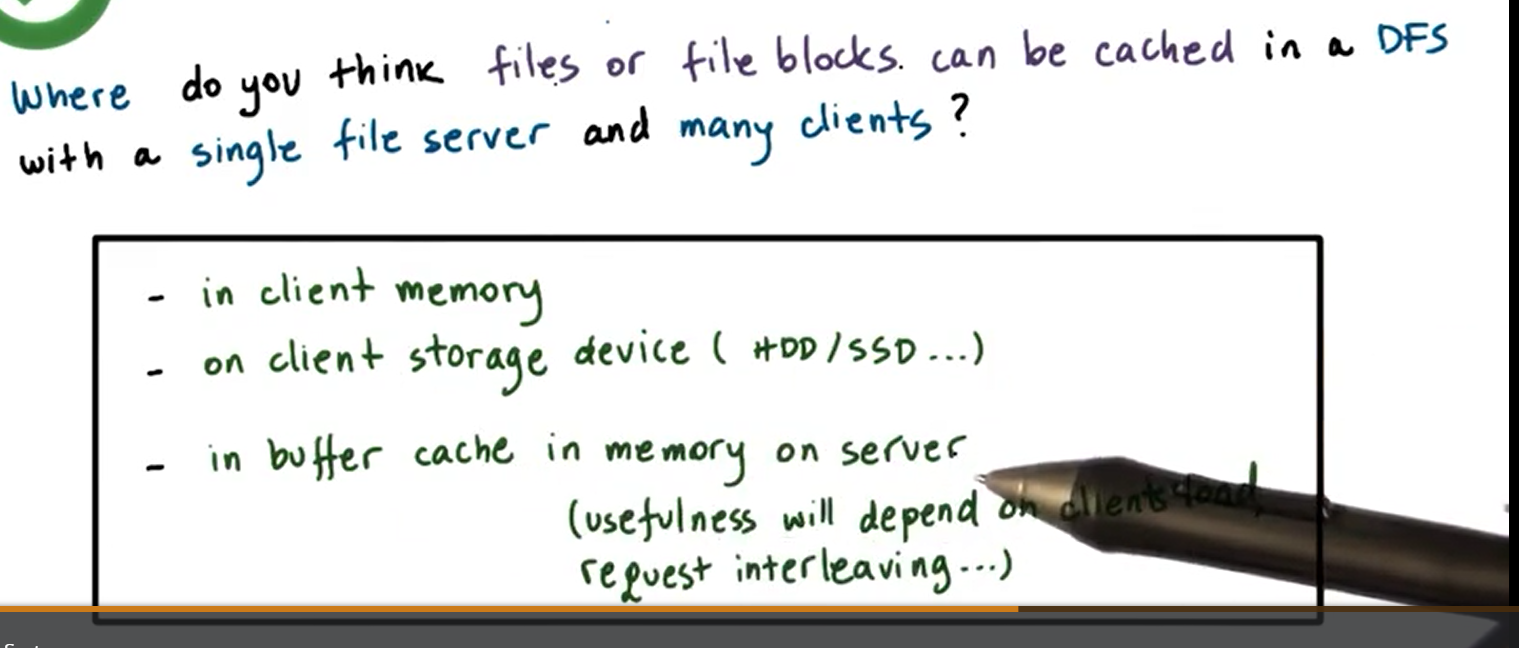

1. In a single machine any modifications can be seen by all processes, even the modification hasn't been pushed to disk. Because all process can see the buffer cache
1. In DFS, even pushed to file server immediately, other clients may not see the modification immediately (message latency)
    1. DFS sacrify some consistence
### File sharing semantics in DFS
    1. UNIX semantics => every write visible immediately
    1. session semantics (between open-close =>session)
        1. write back on close()
        1. update on open()
        1. easy to reason but may be insufficenty
            1. many clients access/update the same file
            1. opened for a long time
    1. periodic updates
        1. client writes-back periodically
            1. clients have a lease on cached data (not exclusive necessarily)
            1. server invalidates periodically => provides bounds on inconsistency
            1. augment with flush()/sync() API
    1. immutable files => 
        1. never modify 
        1. new files created
    1. transactions:
        1. all changes atomic

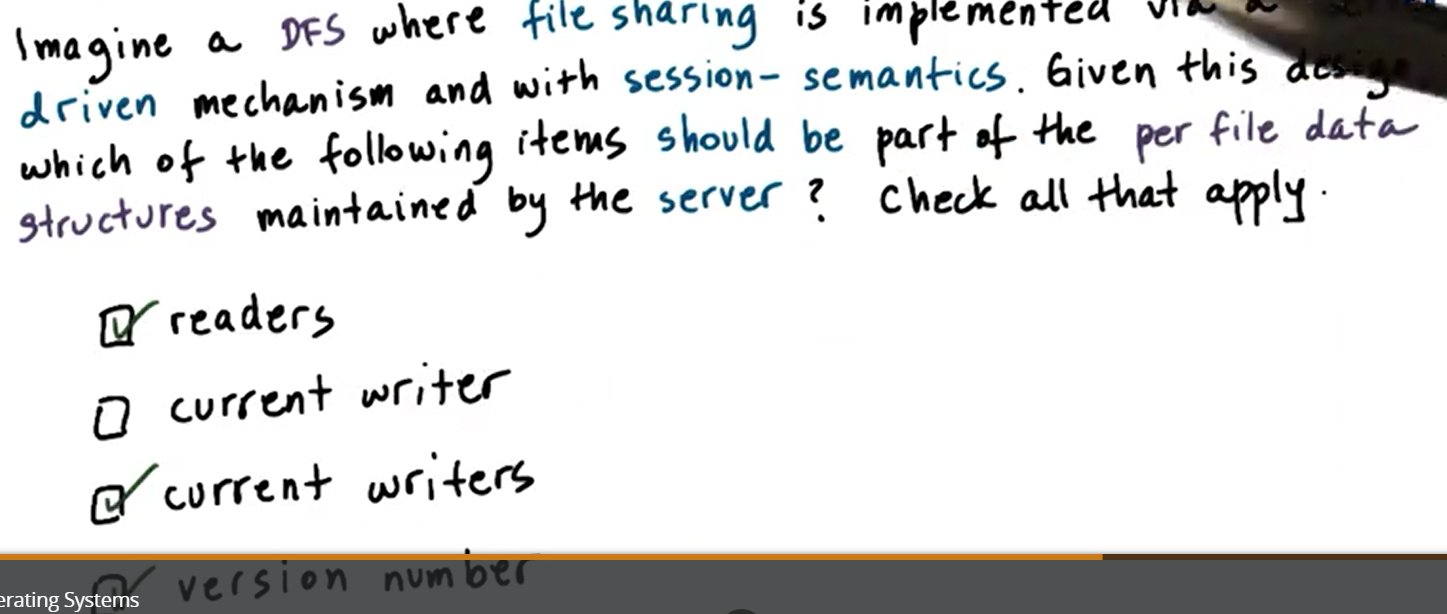

### Knowing the Access Patterns
1. too many options?
    1. sharing frequency
    1. write frequency
    1. importance of consistent view
1. optimize for common case
1. two types of files
    1. regualr files vs directories
    1. different policies for each
        1. session-semantics for files, UNIX for directories
        1. less frequent write-back for files than directories

### Replication vs Partitioning
1. replication
    1. each machine holds all files
    1. pros:
        1. load balancing
        1. avaiablity 
        1. fault tolerance
    1. cons
        1. writes become more complex
            1. synchronously to all
            1. or write to one then propagated to others
        1. replicas must be reconsiled
            1. vote
1. partitioning
    1. each machine has subste of files
    1. pros:
        1. avaiability vs single server DFS 
        1. scalability wit h file system size
        1. single file writes simpler
    1. cons:
        1. on failure, lose portion of data
        1. load balancing harder if not balanced then hot spots possible
1. can combine both techniques: replicate each partition

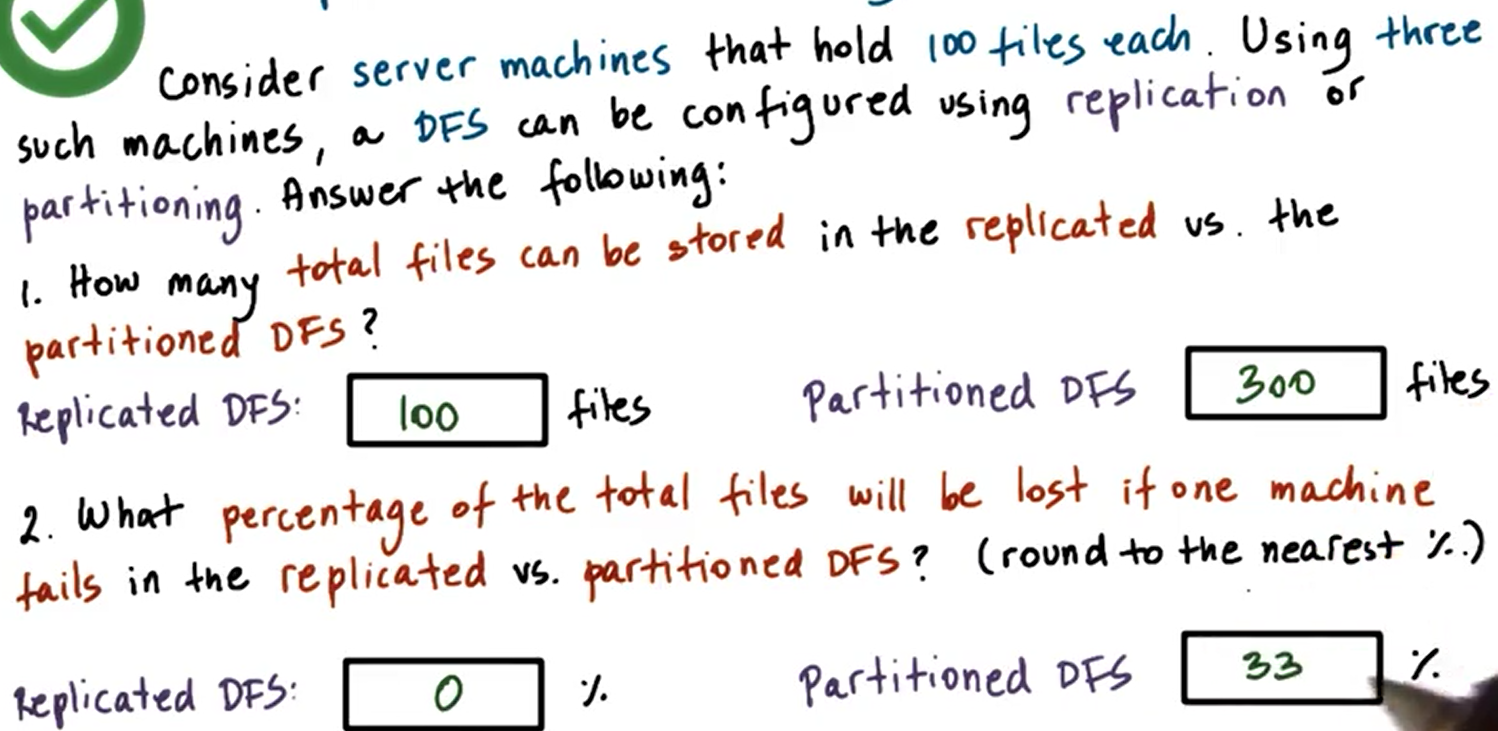

### Network File System
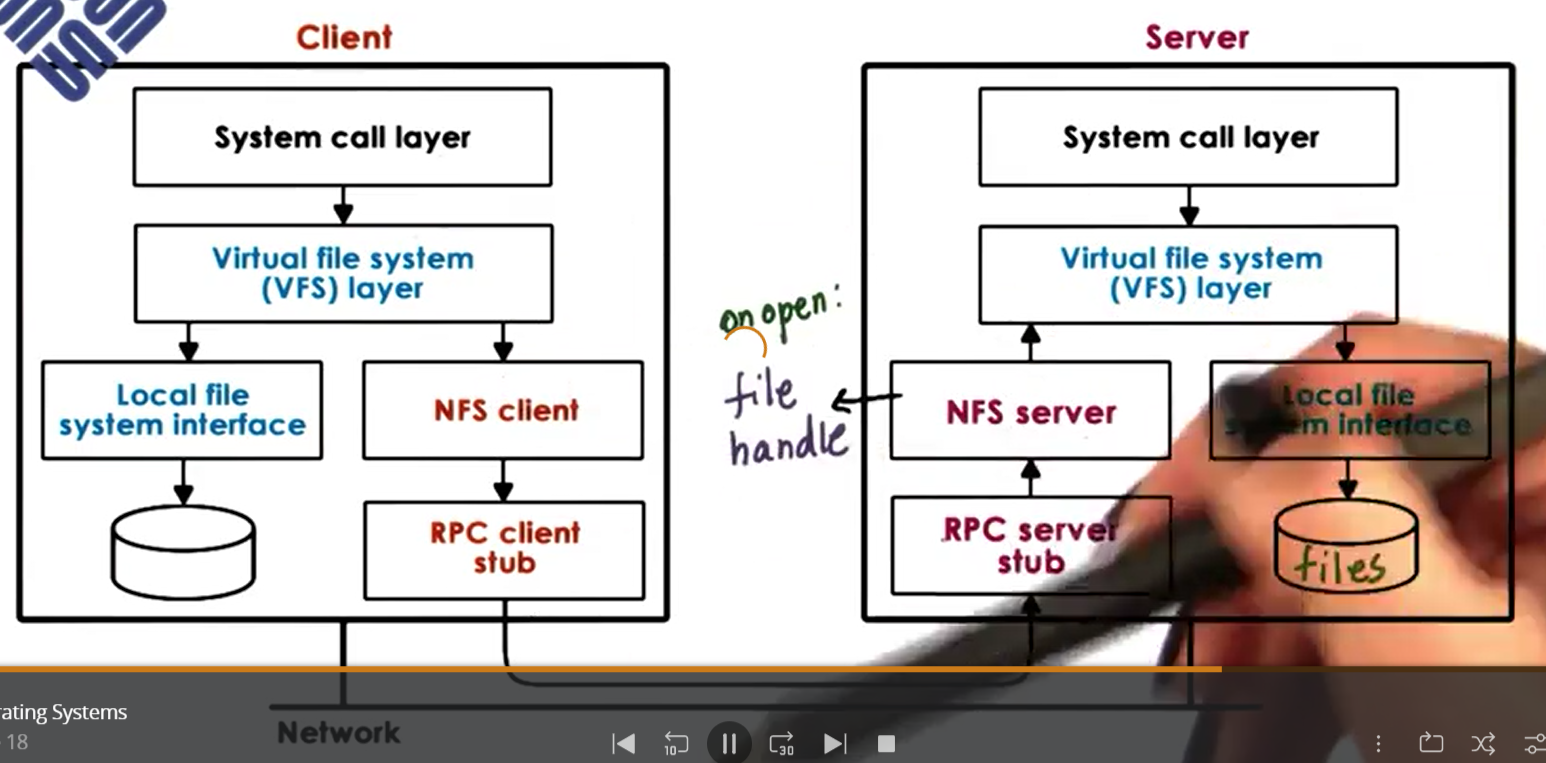
1. client requests an access files using the virtual file system interface with the same types of descriptors they use to access their local files
1. the VSF layer determine whether file belongs to local file system or it needs to be pushed to the NFS client
1. the NFS client interacts via RPC with their NFS server on remote machine
1. NFS accepts the request, form them into a proper file system operation issued to local virtual file system
1. operations are passed to local file system
1. on server machine, the requests come from the NFS server module
1. when an open request cames from the client, the NFS server will create a file handle
    1. a bit sequence that encodes both the server machien and the server local file information
    1. returned back to the client machine
    1. it will be maintained by NFS client
    1. whenever the client application tries to access files that are stored on the remote server on NFS, internally this fiel handle will be passed with every single request
    1. if the file gets deleted, or the server machine dies, using this handle will result in an error due to stale data (data no longer valid)
1. on client's write operations, data needs to be written to the file will be carried as part of the RPC request from the client to the server machine
1. in file read, the data block taht will be read from teh file will be the results form that RPC request that was sent from client to the server
    1. they will be passed back to the NFS client and back to the application issued the read operation

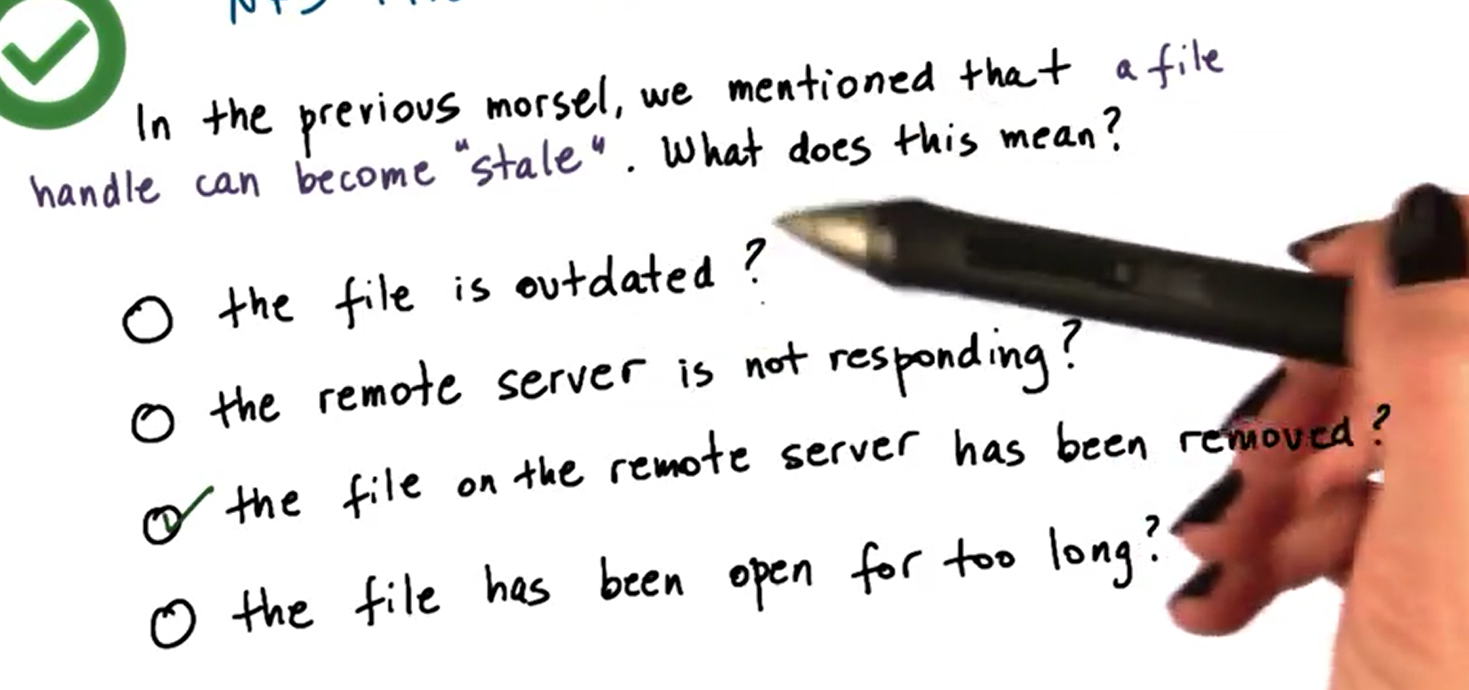
1. consistence related problem
1. RPC layer problem
1. correct


### NFS Versions
1. since 80s.. wrrently NFSv3 and NFSv4
    1. NFSv3 == stateless
        1. need additional modele to support client caching and clinet locking
    1. NFSv4 == stateful
        1. support client caching and clinet locking
1. caching
    1. session-based (for file not accessed concurrently)
        1. on-close => flush to remote server disk 
        1. on open, acheck is performed
        1. if necessary, the cached parts of the file are updated
    1. periodic updates (when there are multi client concurrently updating a file)
        1. default: 3sec for iles, 30 seconds for directories 
            1. directories as files are modified less frequently
            1. when modified it's easier to merge those changes
        1. NFSv4 => delegation all rights to manage a file to client for a period of time (avoid "update  checks")
1. locking
    1. lease-based 
    1. when a client acquires a lock, the server assigns it a particular time period during which the lock is valid
    1. client's respoinsibiltiy to make sure that it either 
        1. releases the lock within the leased amount of time
        1. or it explicitly extends the lock duration
    1. or the client expired and we can assign the lock to someone else
    1. when client comes back it will know the lease expired, it no long has the lock
    1. NFSv4 supports more sophisticated mechanisms 
        1. share reservation: reader/writer lock
            1. upgrade from being a reader to writer for a file and vice versa

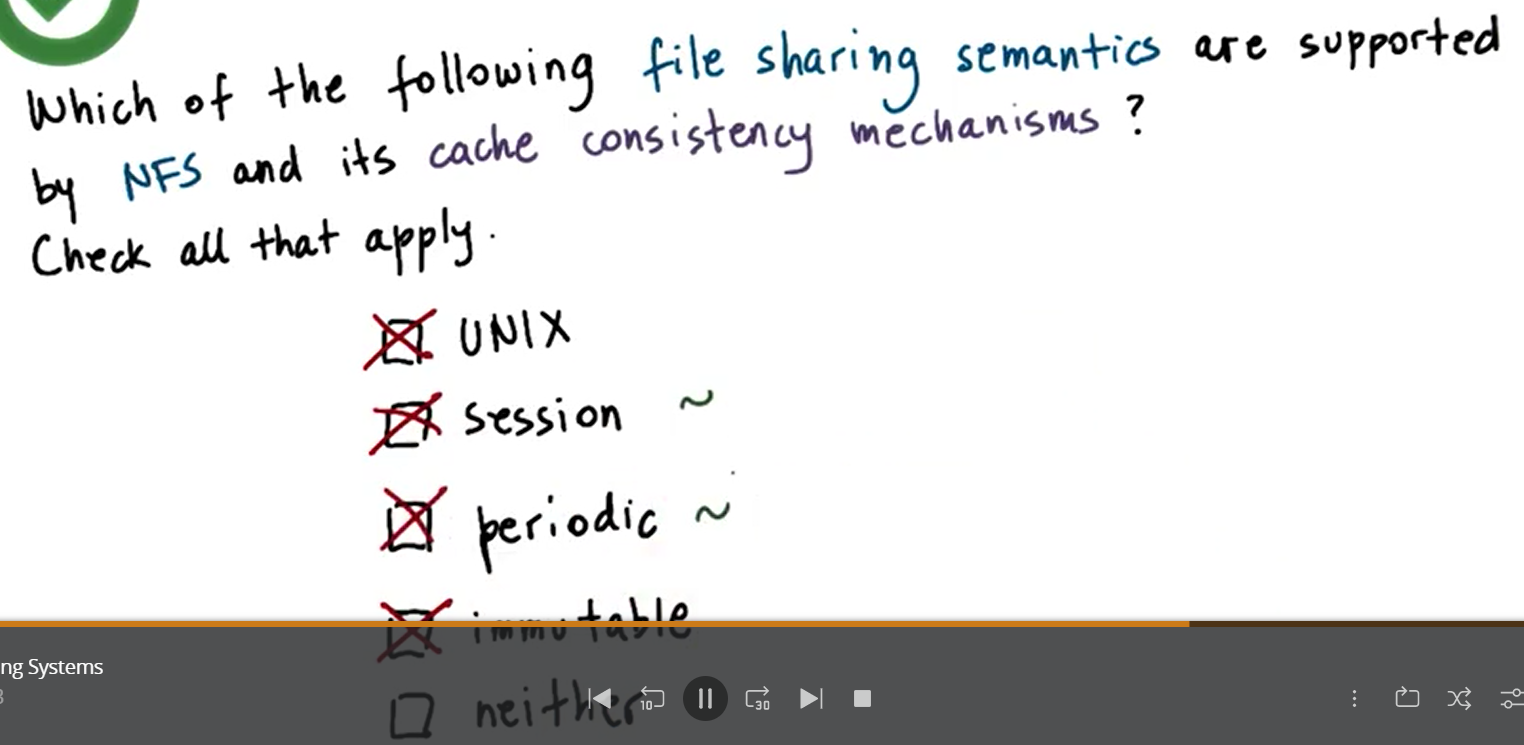
1. doesn't make guranttee that update to a file will be immediately visible
1. given the option for periodic updates exists, it's not quite a session semantics
1. NFS tries to make session semantics
    1. the updates made to a file will be flushed back to the server when the file is closed
    1. when client performs an open operation, the client can check with the server if  the file has been updated
    1. NFS can be configured to periodically have the client and server interations that check for any intermediate updates  during a session
    1. NFS always behave like with session semantics
1. all files are modifiable

1. whether it behaves like with session or periodic semantics depends on how NFS is configured
1. by default, NFS is neither purely session-based file sharing semantics nor purely support periodic file sharing semantics

## Sprite Distributed File System
1. "Caching in the Sprite Network File System" by Nelson et al
    1. research DFS, not a production file system
    1. great value in the explanation of the design process
        1. usage pattern
        1. file access pattern
        1. motivated the particular design of Sprite
    1. used trace data on usage/file access patterns to analyze DFS design requirements and justify decisions

### Access Pattern (workload) analysis
1. 33% of all file accesses are writes
1. file sahring is rare
    1. caching can be important for 67% 
    1. caching is OK but write-through not sufficient: 
        1. if update with write through with every single write => 33% is not able to use the fact there is a local cache on the client side         
1. 75% of files are open less than 0.5 sec
1. 90% of files are open less than 10 sec
    1. how about session semantics
        1. with session semantics, they will need to perform updates to the remote server within less than 0.5 sec for many of the files 
        1. within less than 10 sec for most of the files
        1. too high overhead: session semantics is not going so solve the problems: too many interactions with the remote file server        
1. 20-30% of new data delelted within 30 sec
1. 50% of new data deleted within 5 minutes
    1. write back on close not really necessary
    1. no need to optimize for concurrent access but must support it

### From Analysis to Design
1. cache with write-back
    1. every 30sec write-back blocks that have not been modified for the last 30 sec
    1. when another cliente opens file
        1. server contacts the editing client and get dirty blocks
    1. open goes to serer, directories not cached 
        1. client can't perform a directories related operation directly using its cache only. It has to go to the server
            1. looks up a file
            1. opens a file
            1. create a file 
    1. on concurrent write
        1. disable cachine
        1. all of the writes will be serialized at the server side
1. Sprite sharing semantics
    1. sequential write sharing 
        1. caching and sequential semantics
    1. concurrent write sharing
        1. no caching

### File Access Operations in Sprite
1. R1...Rn readers, w, writer
    1. all open() go through server
    1. server allows all accesses
    1. all clients cache blocks
    1. writer keep timestamps for each modified block (to enforce the write back policy every 30 secs) 
        1. writer can close and open to modify more
        1. the content of the file are cached locally in the writer's cache
        1. open still has to go to the server
        1. the writer need to check with the server whether its cached value is the same as what the server sees: they need to keeep some version numbers
    1. client need to keep track of some information for each file
        1. status whether the file is in the cache
        1. what are all the cached blocks from that file
        1. for all of the firty block when were they modifeid last: so that we can run the write back mechanism 
        1. version number
    1. server keeps track of some information
        1. current readers
        1. writer
        1. current version of the file
1. after w1 closed the file, writer W2 sequential writer(not to write the file at the same time) shows up (sequential sharing)
    1. server contacts last writer for dirty blocks, 
    1. if W1 has closed updated version 
    1. w2 can now cache file
1. W3 concurrent writer (concurrent sharing)
    1. server contacts last writer for dirty blocks
    1. since W2 hasn't closed => disable caching
    1. server need to maintain if a file is cachable
1. if W2 or W3 closes the file
    1. server will see the close operation
    1. server will change the cacheable flag to yes (file cacheable)
1. unique feature of Sprite:
    1. dynamically enable/disable caching